Import packages

In [1]:
import tensorflow as tf
import create_dataset
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Define generic functions to visualize data

In [2]:
def showImage(im):
    if (im.shape[2] == 1):
        im = im[:, :, 0]
    plt.imshow(im)
    plt.show()

Define generic functions to initialize weight/bias variables, and to define common convolution and pooling operations

In [3]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial, name='weights')

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial, name='biases')

In [4]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

Define the network architecture + loss function and metrics

In [5]:
# Input/Output placeholders
x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name='input')
y_ = tf.placeholder(tf.float32, shape=[None, 2], name='output')

num_fc_layers = 10

# Layer 1
with tf.name_scope('1/Conv'):
    W_conv1 = weight_variable([1, 1, 1, 32])
    b_conv1 = bias_variable([32])
    x_image = tf.reshape(x, [-1, 28, 28, 1])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

print h_pool1.shape

# Layer 2
with tf.name_scope('2/Conv'):
    W_conv2 = weight_variable([1, 1, 32, 64])
    b_conv2 = bias_variable([64])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)

print h_pool2.shape

layers = [tf.reshape(h_pool2, [-1, 7*7*64])]
keep_prob = tf.placeholder(tf.float32)
prev_layer_size = 7*7*64                     
# Create FC layers
for i in range(0, num_fc_layers):
    with tf.name_scope('{}/FC'.format(i)):
        W_fc = weight_variable([prev_layer_size, 1024])
        b_fc = bias_variable([1024])
        if i < num_fc_layers/3:
            h_fc = tf.nn.relu(tf.matmul(layers[-1], W_fc) + b_fc)
        else: 
            h_fc = tf.nn.tanh(tf.matmul(layers[-1], W_fc) + b_fc)
        h_fc_drop = tf.nn.dropout(h_fc, keep_prob)
        layers.append(h_fc_drop)
        prev_layer_size = 1024

# Readout
with tf.name_scope('5/Readout'):
    W_fc2 = weight_variable([1024, 2])
    b_fc2 = bias_variable([2])
    y_conv = tf.matmul(layers[-1], W_fc2) + b_fc2
    norm_y_conv = tf.nn.l2_normalize(y_conv, dim=0)

# Define loss
l2_loss = tf.reduce_mean(
    tf.nn.l2_loss(tf.subtract(norm_y_conv, y_)) + 0.01*tf.nn.l2_loss(tf.subtract(norm_y_conv, y_conv)))
train_step = tf.train.AdamOptimizer(1e-4).minimize(l2_loss)

(?, 14, 14, 32)
(?, 7, 7, 64)


Train the network per-batch

step 0, training loss 0.808393
step 20, training loss 1.02857
step 40, training loss 0.970555
step 60, training loss 0.624264
step 80, training loss 1.14861
step 100, training loss 0.431809
step 120, training loss 0.43168
step 140, training loss 0.610557
step 160, training loss 0.610558
step 180, training loss 0.610558
step 200, training loss 0.431673
step 220, training loss 0.789443
step 240, training loss 0.610557
step 260, training loss 0.610556
step 280, training loss 0.789443
step 300, training loss 0.968327
step 320, training loss 0.789443
step 340, training loss 0.789443
step 360, training loss 1.14721
step 380, training loss 0.789443
step 400, training loss 0.789441
step 420, training loss 0.431671
step 440, training loss 0.610558
step 460, training loss 0.789443
step 480, training loss 0.968329
step 500, training loss 0.789443
step 520, training loss 0.610559
step 540, training loss 0.968328
step 560, training loss 0.610557
step 580, training loss 0.431672
step 600, training l

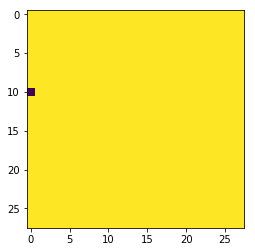

True angle: 3.14159265359
True sin/cos: [  1.22464680e-16  -1.00000000e+00]
Predicted angle: [-0.44721562 -0.44721308]


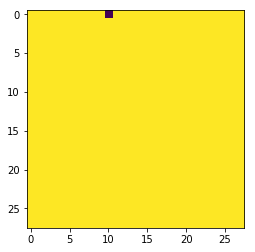

True angle: 4.71238898038
True sin/cos: [ -1.00000000e+00  -1.83697020e-16]
Predicted angle: [-0.44721091 -0.44721451]


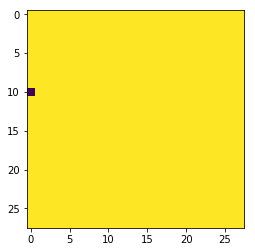

True angle: 3.14159265359
True sin/cos: [  1.22464680e-16  -1.00000000e+00]
Predicted angle: [-0.44721562 -0.44721308]


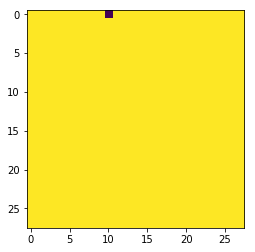

True angle: 4.71238898038
True sin/cos: [ -1.00000000e+00  -1.83697020e-16]
Predicted angle: [-0.44721091 -0.44721451]


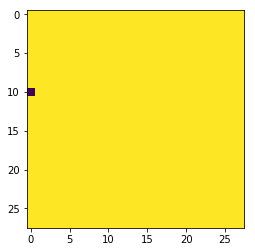

True angle: 3.14159265359
True sin/cos: [  1.22464680e-16  -1.00000000e+00]
Predicted angle: [-0.4472149  -0.44721273]


In [6]:
batch_size = 5
logging_frequency = 20
iterations = 800

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(iterations):
    batch = create_dataset.generate_data_circle(batch_size)
    if i % logging_frequency == 0:
      loss = sess.run(l2_loss, feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0}) 
      print('step %d, training loss %g' % (i, loss/batch_size))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0})
    
  visualization_size = 5
  vis_batch = create_dataset.generate_data_circle(visualization_size)
  output = sess.run(norm_y_conv, feed_dict={x: vis_batch[0], y_: vis_batch[1], keep_prob: 1.0})
  for i in range(visualization_size):
    showImage(vis_batch[0][i])
    print ("True angle: " + str(vis_batch[2][i][0]))
    print ("True sin/cos: " + str(vis_batch[1][i]))
    print ("Predicted angle: " + str(output[i]))